## Solving a Basic HANK Model

In this notebook, we solve an one-asset HANK inspired in Auclert et al (2021) "SSJ paper", Auclert et al (2023) "IKC paper" and McKay, Nakamura, and
Steinsson (2016).

The model description will follow closely the SSJ notebook. It is a HA version of the textbook New Keynesian model (with price rigidity not wage rigity). 

The asset demand and labor supply functions $\{\mathcal{A}, \mathcal{L}\}$ follow from the household block with Bellman equation

$$
\begin{align} \tag{HH}
V_t(e, a_{-}) = \max_{c, n, a} &\left\{\frac{c^{1-\sigma}}{1-\sigma} - \varphi \frac{n^{1+\nu}}{1+\nu} + \beta \mathbb{E}_t\left[V_{t+1}(e', a)|e \right] \right\}
\\
c + a &= (1 + r_t)a_{-} + w_t e n - \tau_t \bar{\tau}(e) + d_t \bar{d}(e)
\\
a &\geq 0
\end{align}
$$

where $\bar\tau(e)$ and $\bar d(e)$ are skill-specific incidence rules for taxes and dividends. 

A competitive final goods firm aggregates a continuum of intermediate goods, indexed by $j$, with a constant elasticity of substitution $\mu/\mu − 1) > 1$. Intermediate
goods are produced by monopolistically competitive firms with production function $y_{jt} = F(n_{jt}) ≡ {Z}_tn_{jt}$. We assume that every firm employs a representative workforce.

We will first assume price rigity, later we study what happens when introduce wage rigity instead. Each firm sets the price of its product $p_{jt}$ subject to quadratic adjustment costs 

$$
\psi_{t}(p_{jt}, p_{jt−1}) = \dfrac{\mu}{\mu-1}\dfrac{1}{2\kappa} [\log(p_{jt}/p_{jt−1})]^2 Y_t
$$

In the symmetric equilibrium, aggregate inflation $1 + \pi_t \equiv P_t/P_{t-1}$ evolves according to the Phillips curve:

$$
\log(1+\pi_t) = \kappa \left(\frac{w_t}{Z_t} - \frac{1}{\mu} \right)  + \frac{1}{1+r_{t+1}} \frac{Y_{t+1}}{Y_t} \log(1+\pi_{t+1}) 
$$


The fiscal authority spends $G_t$, issues one-period nominal bonds B, and adjusts the level of taxes $\tau_t$ to balance its budget period by period $\tau_t = r_t B + G_t$. Monetary policy sets the nominal rate on bonds according to a standard Taylor rule $i_t = r^*_t + \phi \pi_t $. The Fisher equation is $r_t = (1 + i_{t−1})/(1 + \pi_{t})$.

Market clearing: $Y_t = \int c_{it} di + G_t + \psi_t$, $B = \int a_{it} di$ and $N_t = \int e_{it} n_{it} di$.

The model can be summarized in sequence form as

$$
\textbf{F}_t(\textbf{X}, Z) \equiv 
\begin{pmatrix}
Y_t - Z_t L_t
\\
Y_t \left[1 - \frac{\mu}{\mu-1}\frac{1}{2\kappa} \log(1 + \pi_t)^2\right] - w_t L_t - d_t
\\
r_t B + G_t - \tau_t
\\
r^*_t + \phi \pi_t  - i_t 
\\
1 + r_t - \frac{1+i_{t-1}}{1+\pi_t}
\\
\kappa \left(\frac{w_t}{Z_t} - \frac{1}{\mu} \right)  + \frac{1}{1+r_{t+1}} \frac{Y_{t+1}}{Y_t} \log(1+\pi_{t+1}) - \log(1+\pi_t)
\\
\mathcal{A}_t(\{r_s, w_s, \tau_s, d_s\})  - B
\\
\mathcal{N}_t(\{r_s, w_s, \tau_s, d_s\}) - L_t
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\end{pmatrix},
\qquad t = 0, 1, \dots
$$

where the endogenous variables are $\textbf{X} = (Y, L, r, w, d, \pi, \tau, i)$ and the exogenous variables are $\textbf{Z}=(r^*, Z)$. 


We can think of the model as a directed acyclical graph (DAG) with **3 endogenous inputs** and write it as an implicit function

$$
H(\pi, Y, w; \epsilon, Z) = 0.
$$

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from sequence_jacobian import simple, create_model  # functions
from sequence_jacobian import hetblocks, grids      # modules

# Plot parameters
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 12})

#path = '/Users/tomasrm/Library/CloudStorage/Dropbox/Teaching/Other/BCB HA Course/Codes' # this is only used to save plots


Let's first create the household block. We will use the "hh_labor" from the SSJ package. 

In [17]:
hh = hetblocks.hh_labor.hh
print(f'Inputs: {hh.inputs}')

Inputs: ['a_grid', 'we', 'T', 'r', 'beta', 'eis', 'frisch', 'vphi', 'Pi']


In [18]:

def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, pi_e, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    return e_grid, pi_e, Pi, a_grid

def transfers(pi_e, Div, Tax, e_grid):     # tax is a nE size array
    tax_rule, div_rule = e_grid, e_grid  # Dividend and Taxes are proportional to skill
    div = Div / np.sum(pi_e * div_rule) * div_rule   # Split aggregate dividend among skill groups
    tax = Tax / np.sum(pi_e * tax_rule) * tax_rule   # Split aggregate tax among skill groups
    T = div - tax
    return T  

def wages(w, e_grid):
    we = w * e_grid
    return we

household = hh.add_hetinputs([make_grid, transfers, wages])

def labor_supply(n, e_grid): # function to compute the (heterogeneous) labor supply 
    ne = e_grid[:, np.newaxis] * n
    return ne

household = household.add_hetoutputs([labor_supply])


print(household)
print(f'Inputs: {household.inputs}')
print(f'Outputs: {household.outputs}')
print(f'Micro outputs: {household.internals}')

<HetBlock 'hh' with hetinput 'make_grid_transfers' and with hetoutput `labor_supply'>
Inputs: ['r', 'beta', 'eis', 'frisch', 'vphi', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Div', 'Tax', 'w']
Outputs: ['A', 'C', 'N', 'NE']
Micro outputs: ['D', 'Dbeg', 'Pi', 'Va', 'a', 'c', 'n', 'ne', 'e_grid', 'pi_e', 'a_grid', 'T', 'we']


#### Adding Firm Fiscal Side and Market Clearing

Let's add the government (fiscal and monetary rules) and market clearing.
Note that we have two NKPC: one for the steady state and the dynamic for the transition. 

It could work with only the dynamic, but sometimes using the analytical solution can save you some cost to solve (and calibrate) the model in the steady state. We use the fact that in the SS:

$$
w = \frac{Z}{\mu} \tag{ss wage}
$$

The simplest way of doing so is to work with two DAGs: one for calibration and one for transition dynamics. Typically, the two DAGs share some, but not all of their blocks. Furthermore, they may have different unknowns and targets. 




In [19]:
@simple
def mkt_clearing(A, NE, C, L, Y, B, G, pi, mu, kappa):
    asset_mkt = A - B
    labor_mkt = NE - L
    goods_mkt = Y - C - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y  - G
    return asset_mkt, labor_mkt, goods_mkt


@simple
def nkpc_ss(Z, mu):  # NKPC in the Steady State
    w = Z / mu
    return w

@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):   # NKPC in the Transition Dynamics
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
               - (1 + pi).apply(np.log)
    return nkpc_res

@simple
def firm(Y, w, Z, pi, mu, kappa):
    L = Y / Z
    Div = Y - w * L - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y
    return L, Div


@simple
def monetary(pi, rstar, phi):
    r = (1 + rstar(-1) + phi * pi(-1) ) / (1 + pi) - 1
    return r


@simple
def fiscal(r, B, G):
    Tax = r * B + G
    return Tax


blocks_ss = [household, firm, monetary, fiscal, mkt_clearing, nkpc_ss]
hank_ss = create_model(blocks_ss, name="One-Asset HANK SS")

print(hank_ss)
print(f"Inputs: {hank_ss.inputs}")



<Model 'One-Asset HANK SS'>
Inputs: ['beta', 'eis', 'frisch', 'vphi', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Y', 'Z', 'pi', 'mu', 'kappa', 'rstar', 'phi', 'B', 'G']



We calibrate the discount factor $\beta$ and disutility of labor $\varphi$ to hit a target for the interest rate and effective labor $L=1.$ Additionally we calibrate the wage $w$ such that the Phillips curve relation is satisfied in steady state for zero inflation $\pi=0$.



In [20]:
# Internal calibration

calibration = {'eis': 0.5, 'frisch': 0.5, 'rho_e': 0.966, 'sd_e': 0.8, 'nE': 7,
               'amin': 0.0, 'amax': 150, 'nA': 500, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
               'mu': 1.2, 'kappa': 0.1, 'rstar': 0.005, 'phi': 1.5, 'B': 5.6, 'G': 0.0} # phi: 1.5

unknowns_ss = {'beta': 0.986, 'vphi': 0.8}   # 
targets_ss = {'asset_mkt': 0, 'labor_mkt': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")

print(f"Asset market clearing: {ss0['asset_mkt']: 0.2e}")
print(f"Labor market clearing: {ss0['labor_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss0['goods_mkt']: 0.2e}")

Asset market clearing:  2.66e-14
Labor market clearing: -1.22e-15
Goods market clearing (untargeted): -2.73e-09


Let's plot the labor supply policy as function of assets by skill type. We see that poorer households work more when wealth-constrained, but more productive households choose to work more if wealth-rich.

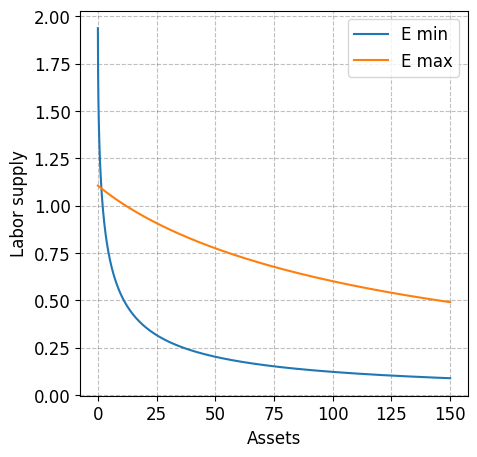

In [21]:
fig, ax1 = plt.subplots(1,1,figsize=(5, 5)) # Ax1 is consumption ax2 is savings

ax1.plot(ss0.internals['hh']['a_grid'],ss0.internals['hh']['n'][0,:], label = 'E min')
ax1.plot(ss0.internals['hh']['a_grid'],ss0.internals['hh']['n'][-1,:], label = 'E max')
plt.xlabel('Assets'), plt.ylabel('Labor supply')
ax1.legend(frameon=True)
#plt.savefig(path + "/l_supply.png", bbox_inches='tight')
plt.show()


Let's test the dynamic properties of this simple model. We must create a new DAG with the dynamic NKPC. 
Note that we can use the steady state solution of the previous model (where we use the analytical NKPC in steady state).

In [22]:
# Dynamics of one asset HANK
hank = create_model([household, firm, monetary, fiscal, mkt_clearing, nkpc], name="One-Asset HANK")

print(*hank.blocks, sep='\n') # this plot the order of the DAG
ss = hank.steady_state(ss0) # note that we use as input the steady state solved using the other DAG.

#for k in ss0.keys(): # check if both SS are similar
#    assert np.all(np.isclose(ss[k], ss0[k]))

# Solve for the Jacobians in the Sequence Space
T = 300
exogenous = ['rstar', 'Z']
unknowns = ['pi', 'w', 'Y']
targets = ['nkpc_res', 'asset_mkt', 'labor_mkt']

# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)
print(G)


<SimpleBlock 'monetary'>
<SimpleBlock 'nkpc'>
<SimpleBlock 'fiscal'>
<SimpleBlock 'firm'>
<HetBlock 'hh' with hetinput 'make_grid_transfers' and with hetoutput `labor_supply'>
<SimpleBlock 'mkt_clearing'>
<JacobianDict outputs=['pi', 'w', 'Y', 'A', 'C', 'N', 'NE', 'L', 'Div', 'r', 'Tax', 'asset_mkt', 'labor_mkt', 'goods_mkt', 'nkpc_res'], inputs=['rstar', 'Z']>


Then we solve for productivity shocks of different persistences and monetary policy shocks. 

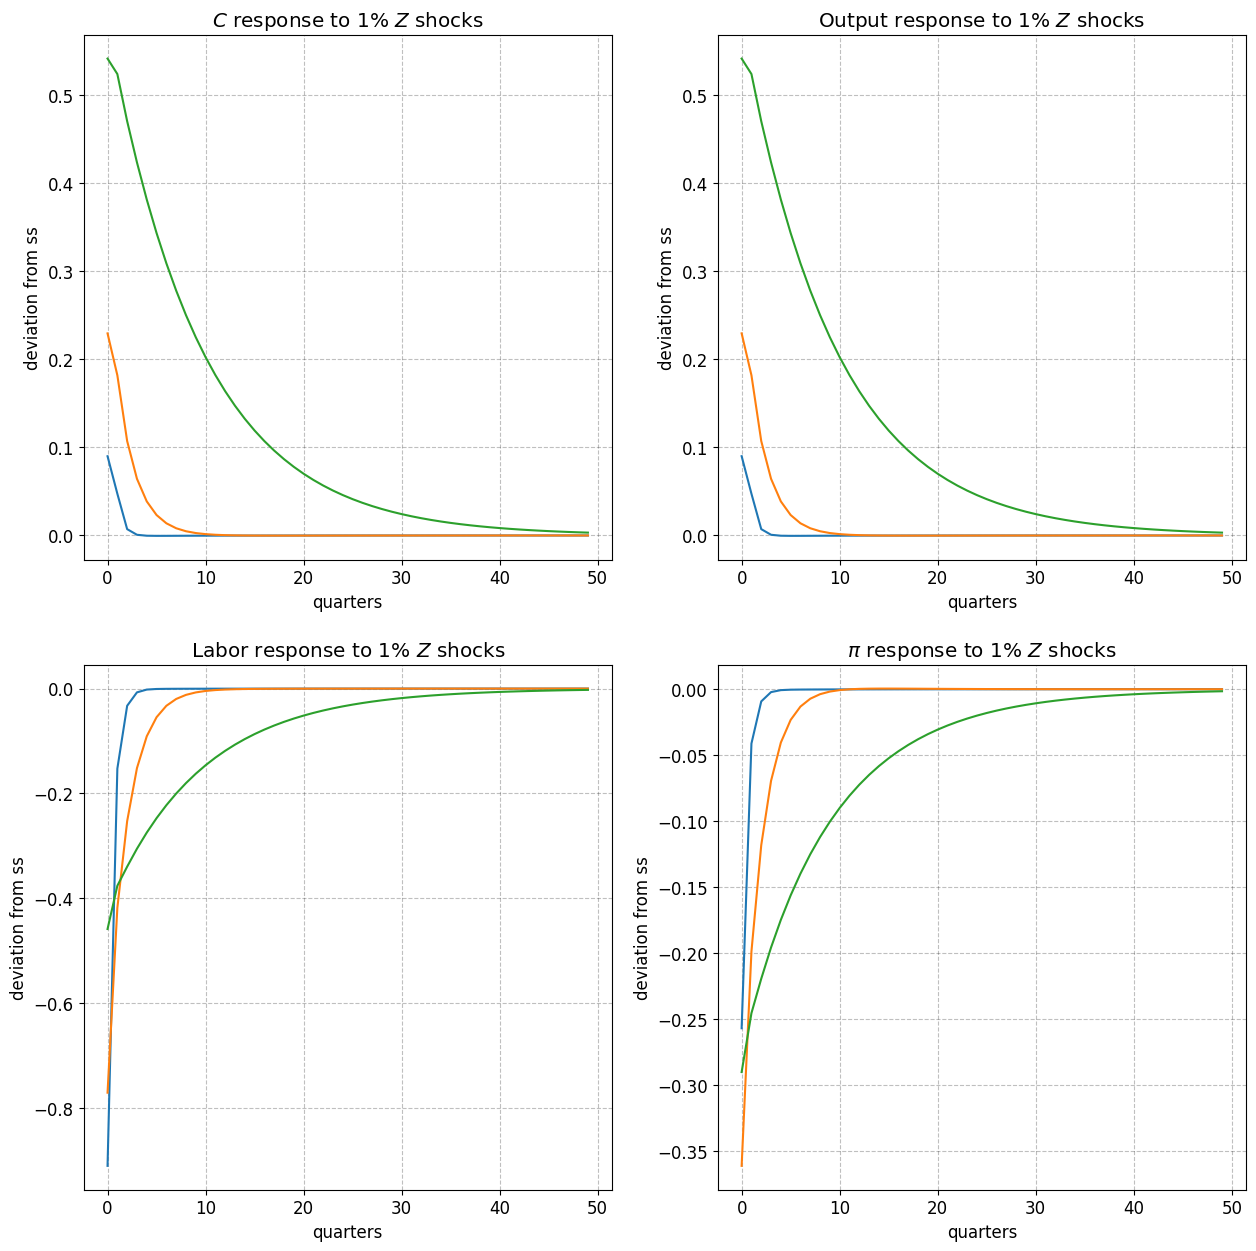

In [31]:
rhos = np.array([0.2, 0.6, 0.9])
dZ = 0.01 * ss['Z'] * rhos ** (np.arange(T)[:, np.newaxis])
#print(dZ)

dc = G['C']['Z'] @ dZ
da = G['A']['Z'] @ dZ
dr = G['r']['Z'] @ dZ
dpi = G['pi']['Z'] @ dZ
ddiv = G['Div']['Z'] @ dZ
dne = G['NE']['Z'] @ dZ
dy = G['Y']['Z'] @ dZ


fig, axs = plt.subplots(2,2,figsize=(15, 15))

axs[0,0].plot(100*dc[:50, :])
axs[0,0].set_title(r'$C$ response to 1% $Z$ shocks')
axs[0,0].set_ylabel(r'deviation from ss')
axs[0,0].set_xlabel(r'quarters')

axs[0,1].plot(100*dy[:50, :])
axs[0,1].set_title(r'Output response to 1% $Z$ shocks')
axs[0,1].set_ylabel(r'deviation from ss')
axs[0,1].set_xlabel(r'quarters')

axs[1,0].plot(100*dne[:50, :])
axs[1,0].set_title(r'Labor response to 1% $Z$ shocks')
axs[1,0].set_ylabel(r'deviation from ss')
axs[1,0].set_xlabel(r'quarters')
#plt.savefig(path + "/policy_func.png", bbox_inches='tight')

axs[1,1].plot(100*dpi[:50, :])
axs[1,1].set_title(r'$\pi$ response to 1% $Z$ shocks')
axs[1,1].set_ylabel(r'deviation from ss')
axs[1,1].set_xlabel(r'quarters')

plt.show()



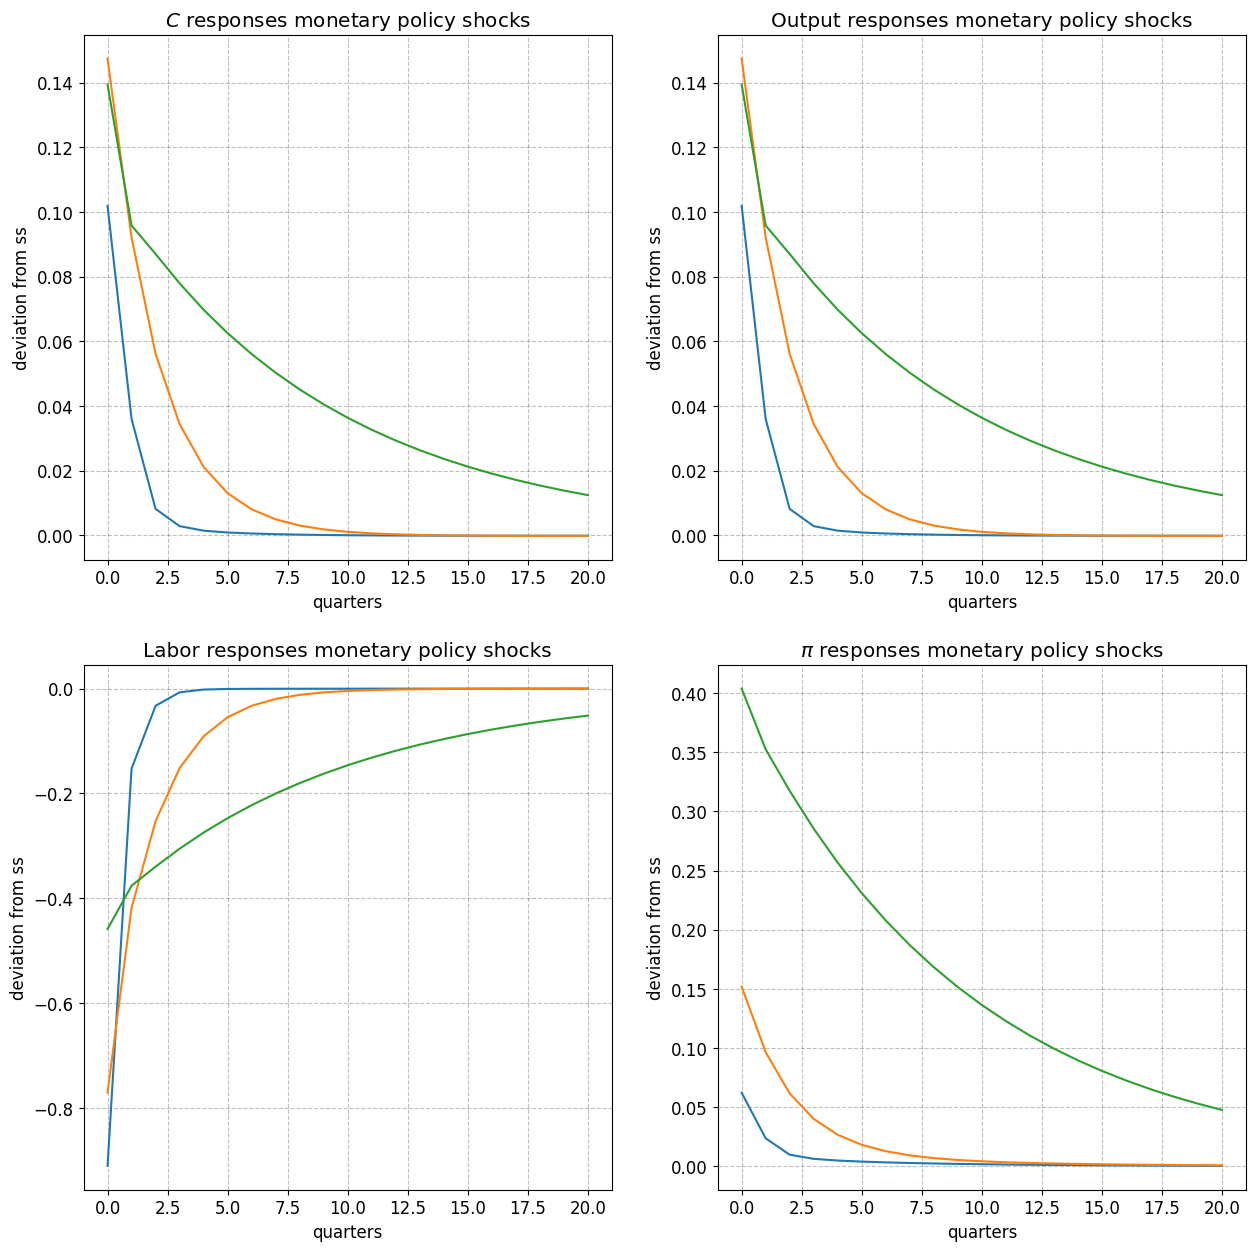

In [32]:

rhos = np.array([0.2,  0.6, 0.9])
drstar = -0.0025 * rhos ** (np.arange(T)[:, np.newaxis]) # positive monetary policy
dpi = G['pi']['rstar'] @ drstar
dc = G['C']['rstar'] @ drstar
dy = G['Y']['rstar'] @ drstar
ddiv = G['Div']['rstar'] @ drstar
dne = G['NE']['Z'] @ dZ



fig, axs = plt.subplots(2,2,figsize=(15, 15))

axs[0,0].plot(100*dc[:21, :])
axs[0,0].set_title(r'$C$ responses monetary policy shocks')
axs[0,0].set_ylabel(r'deviation from ss')
axs[0,0].set_xlabel(r'quarters')

axs[0,1].plot(100*dy[:21, :])
axs[0,1].set_title(r'Output responses monetary policy shocks')
axs[0,1].set_ylabel(r'deviation from ss')
axs[0,1].set_xlabel(r'quarters')

axs[1,0].plot(100*dne[:21, :])
axs[1,0].set_title(r'Labor responses monetary policy shocks')
axs[1,0].set_ylabel(r'deviation from ss')
axs[1,0].set_xlabel(r'quarters')
#plt.savefig(path + "/policy_func.png", bbox_inches='tight')

axs[1,1].plot(100*dpi[:21, :])
axs[1,1].set_title(r'$\pi$ responses monetary policy shocks')
axs[1,1].set_ylabel(r'deviation from ss')
axs[1,1].set_xlabel(r'quarters')

plt.show()


### MPCs

We have see that MPC's are important. Could we use the fiscal policy to change the aggregate MPC? 
Let's do two modifications on the previous model. First, we will not require to balance budget every period. Second, we are going to define an "hetoutput" function to compute the entire distribution of MPC (and the aggregate MPC). 


In [25]:
@simple
def fiscal_deficit(B, r, G):
    Tax = (1 + r) * B(-1) + G - B  # total tax burden
    deficit = G - Tax
    return Tax, deficit


def compute_weighted_mpc(c, a, a_grid, r, e_grid):
    """Approximate mpc out of wealth, with symmetric differences where possible, exactly setting mpc=1 for constrained agents."""
    mpc = np.empty_like(c)
    post_return = (1 + r) * a_grid
    mpc[:, 1:-1] = (c[:, 2:] - c[:, 0:-2]) / (post_return[2:] - post_return[:-2]) 
    mpc[:, 0] = (c[:, 1] - c[:, 0]) / (post_return[1] - post_return[0])  # lower bound
    mpc[:, -1] = (c[:, -1] - c[:, -2]) / (post_return[-1] - post_return[-2]) # upper bound
    mpc[a == a_grid[0]] = 1   # Set all MPC out of the boundary constraint to 1
    return mpc


household_mpc = household.add_hetoutputs([compute_weighted_mpc])
print(household_mpc)
hank_ss_fiscal = create_model([household_mpc, firm, monetary, fiscal_deficit, mkt_clearing, nkpc_ss], name="One-Asset HANK SS with MPC and Fiscal Policy")
print(hank_ss_fiscal.outputs)



<HetBlock 'hh' with hetinput 'make_grid_transfers' and with hetoutput `compute_weighted_mpc_labor_supply'>
['A', 'C', 'N', 'NE', 'MPC', 'L', 'Div', 'r', 'Tax', 'deficit', 'asset_mkt', 'labor_mkt', 'goods_mkt', 'w']


Let's recalibrate the model. We will also introduce positive government expenditure $G>0$, calibrated to be $20\%$ of output.

In [26]:

calibration['G'] = 0.2

#= {'eis': 0.5, 'frisch': 0.5, 'rho_e': 0.966, 'sd_e': 0.8, 'nE': 7,
#               'amin': 0.0, 'amax': 150, 'nA': 500, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
#               'mu': 1.2, 'kappa': 0.1, 'rstar': 0.005, 'phi': 1.0, 'B': 5.6, 'G': 0.2}

unknowns_ss = {'beta': 0.986, 'vphi': 0.8}   # 
targets_ss = {'asset_mkt': 0, 'labor_mkt': 0}

ss0_Bhigh = hank_ss_fiscal.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")
print('Aggregate MPC with B = 5.6:', ss0_Bhigh['MPC'])



Aggregate MPC with B = 5.6: 0.19118573545249357


The aggregate MPC of the model is not very high. Can we improve it? 
Let's change the government debt and inspect the distribution:

Aggregate MPC with B = 2.0: 0.3177029493426308


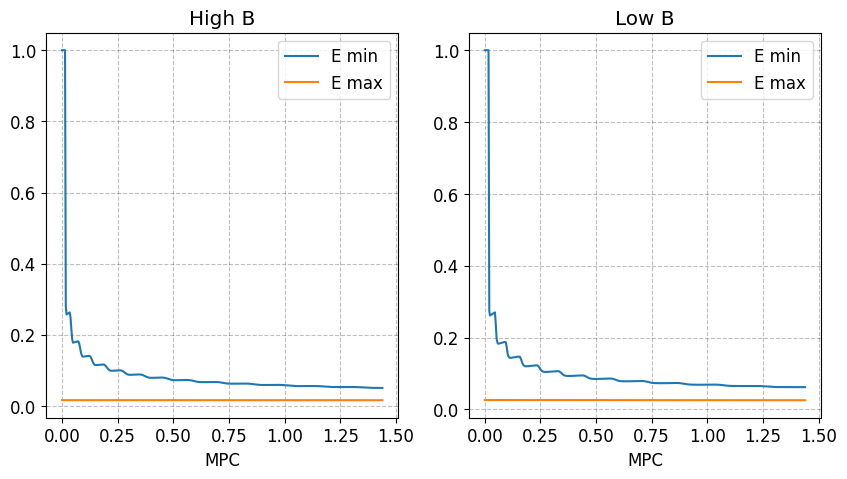

In [27]:
calibration['B'] = 2.0 # Change government debt


# Solve for the SS again
unknowns_ss = {'beta': 0.986, 'vphi': 0.8}   # 
targets_ss = {'asset_mkt': 0, 'labor_mkt': 0}
ss0_Blow = hank_ss_fiscal.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")

print('Aggregate MPC with B = 2.0:', ss0_Blow['MPC'])

# Plot distribution
fig, axs = plt.subplots(1,2,figsize=(10, 5)) # Ax1 is consumption ax2 is savings

axs[0].plot(ss0_Bhigh.internals['hh']['a_grid'][:150],ss0_Bhigh.internals['hh']['mpc'][0,:150], label = 'E min')
axs[0].plot(ss0_Bhigh.internals['hh']['a_grid'][:150],ss0_Bhigh.internals['hh']['mpc'][-1,:150], label = 'E max')
axs[0].set_xlabel('Assets'), axs[0].set_xlabel('MPC'), axs[0].set_title('High B')
axs[0].legend(frameon=True)

axs[1].plot(ss0_Blow.internals['hh']['a_grid'][:150],ss0_Blow.internals['hh']['mpc'][0,:150], label = 'E min')
axs[1].plot(ss0_Blow.internals['hh']['a_grid'][:150],ss0_Blow.internals['hh']['mpc'][-1,:150], label = 'E max')
axs[1].set_xlabel('Assets'), axs[1].set_xlabel('MPC'), axs[1].set_title('Low B')

axs[1].legend(frameon=True)
plt.show()

ss0 = ss0_Blow

### Fiscal Policy

Ok, we saw the debt level of the government is important in the Steady State. What about fiscal policy shocks? Should they be deficit financed or should the government maintain a balanced budget?

Let's shock the one-asset HANK model with different fiscal policy shocks.

In [28]:
# Dynamics of one asset HANK with Fiscal policy
hank_fiscal = create_model([household, firm, monetary, fiscal_deficit, mkt_clearing, nkpc], name="One-Asset HANK with Fiscal Policy")
ss = hank.steady_state(ss0) # note that we use as input the steady state solved using the other DAG.

# Solve for the Jacobians:
T = 300
exogenous = ['rstar', 'Z', 'G', 'B']
unknowns = ['pi', 'w', 'Y']
targets = ['nkpc_res', 'asset_mkt', 'labor_mkt']

G = hank_fiscal.solve_jacobian(ss, unknowns, targets, exogenous, T=T)
print(G)


<JacobianDict outputs=['pi', 'w', 'Y', 'A', 'C', 'N', 'NE', 'L', 'Div', 'r', 'Tax', 'deficit', 'asset_mkt', 'labor_mkt', 'goods_mkt', 'nkpc_res'], inputs=['rstar', 'Z', 'G', 'B']>


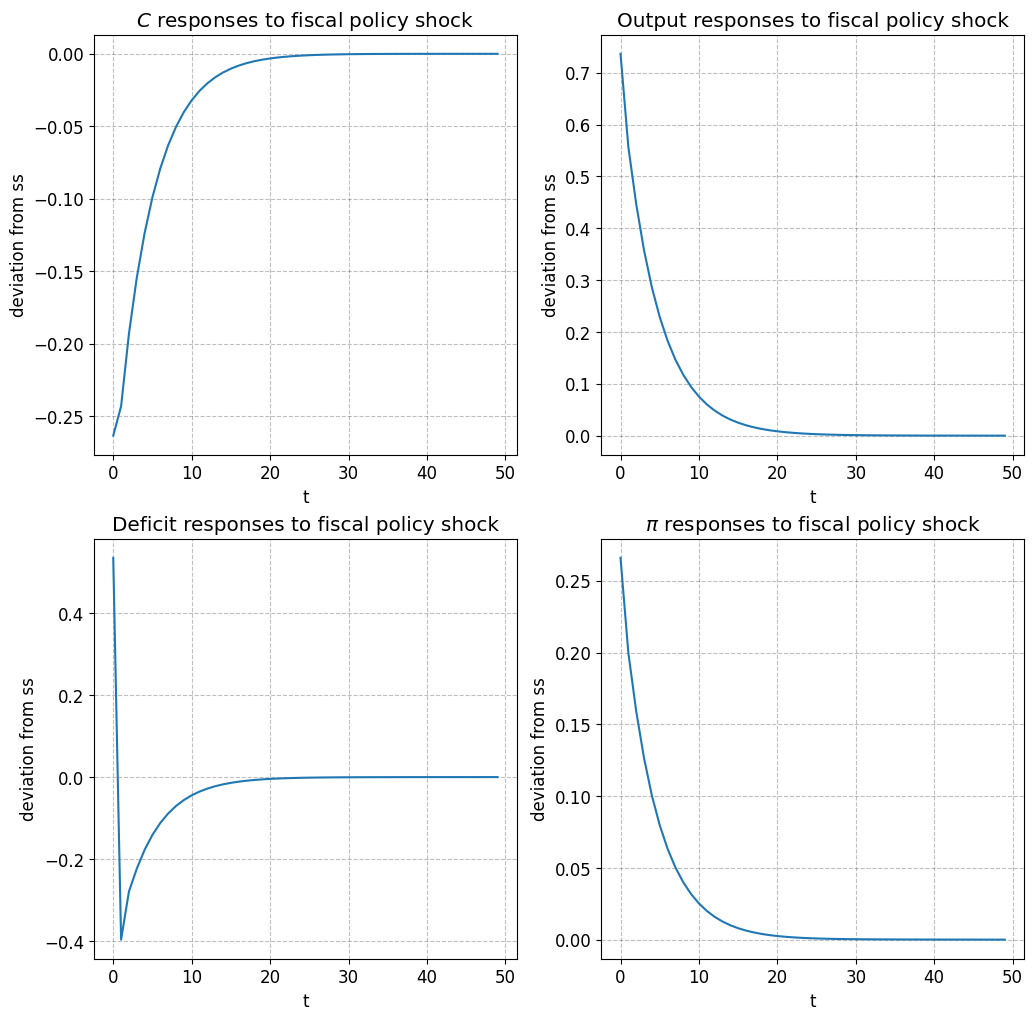

In [29]:
# Construct the shocks.
T = 300  # <-- the length of the IRF
rho_G = 0.8 
dG = 0.01 * rho_G ** np.arange(T) # Fiscal policy shock

dc = G['C']['G'] @ dG
dy = G['Y']['G'] @ dG
dpi = G['pi']['G'] @ dG
ddef = G['deficit']['G'] @ dG
ddiv = G['Div']['G'] @ dG


fig, axs = plt.subplots(2,2,figsize=(12, 12))

axs[0,0].plot(100*dc[:50])
axs[0,0].set_title(r'$C$ responses to fiscal policy shock')
axs[0,0].set_ylabel(r'deviation from ss')
axs[0,0].set_xlabel(r't')

axs[0,1].plot(100*dy[:50])
axs[0,1].set_title(r'Output responses to fiscal policy shock')
axs[0,1].set_ylabel(r'deviation from ss')
axs[0,1].set_xlabel(r't')

axs[1,0].plot(100*ddef[:50])
axs[1,0].set_title(r'Deficit responses to fiscal policy shock')
axs[1,0].set_ylabel(r'deviation from ss')
axs[1,0].set_xlabel(r't')
#plt.savefig(path + "/policy_func.png", bbox_inches='tight')

axs[1,1].plot(100*dpi[:50])
axs[1,1].set_title(r'$\pi$ responses to fiscal policy shock')
axs[1,1].set_ylabel(r'deviation from ss')
axs[1,1].set_xlabel(r't')

plt.show()


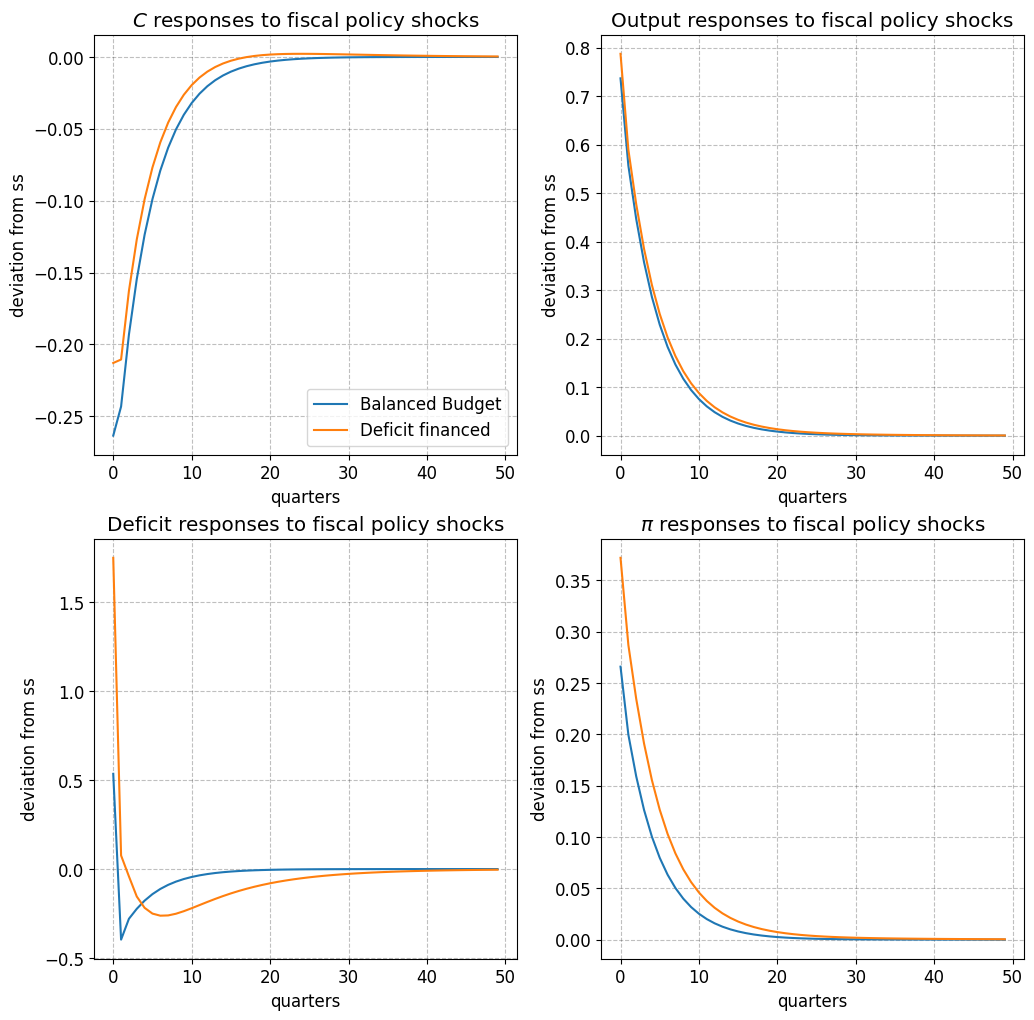

In [30]:
rho_B = 0.9 # Same persistence
#dB = dG[0] * rho_B ** np.arange(T) # Shock is the same size of dG
dB = np.cumsum(dG) * rho_B ** np.arange(T) # Finance everything initicially

dc_def = G['C']['G'] @ dG + G['C']['B'] @ dB 
dy_def = G['Y']['G'] @ dG +  G['Y']['B'] @ dB 
dpi_def = G['pi']['G'] @ dG + G['pi']['B'] @ dB 
ddef_def = G['deficit']['G'] @ dG + G['deficit']['B'] @ dB 
ddiv_def = G['Div']['G'] @ dG + G['Div']['B'] @ dB 


fig, axs = plt.subplots(2,2,figsize=(12, 12))

axs[0,0].plot(100*dc[:50], label = "Balanced Budget")
axs[0,0].plot(100*dc_def[:50], label = "Deficit financed")
axs[0,0].set_title(r'$C$ responses to fiscal policy shocks')
axs[0,0].set_ylabel(r'deviation from ss')
axs[0,0].set_xlabel(r'quarters')
axs[0,0].legend(frameon=True)


axs[0,1].plot(100*dy[:50], label = "Balanced Budget")
axs[0,1].plot(100*dy_def[:50], label = "Deficit financed")
axs[0,1].set_title(r'Output responses to fiscal policy shocks')
axs[0,1].set_ylabel(r'deviation from ss')
axs[0,1].set_xlabel(r'quarters')

axs[1,0].plot(100*ddef[:50], label = "Balanced Budget")
axs[1,0].plot(100*ddef_def[:50], label = "Deficit financed")
axs[1,0].set_title(r'Deficit responses to fiscal policy shocks')
axs[1,0].set_ylabel(r'deviation from ss')
axs[1,0].set_xlabel(r'quarters')

axs[1,1].plot(100*dpi[:50], label = "Balanced Budget")
axs[1,1].plot(100*dpi_def[:50], label = "Deficit financed")
axs[1,1].set_title(r'$\pi$ responses to fiscal policy shocks')
axs[1,1].set_ylabel(r'deviation from ss')
axs[1,1].set_xlabel(r'quarters')

plt.show()

